In [1]:
%matplotlib inline

import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

import statsmodels.formula.api as smf
import statsmodels

import seaborn as sn

In [2]:
# read in Inside Airbnb dataframe
df_2020 = pd.read_csv('2020IA.csv',low_memory=False)
df_2022 = pd.read_csv('2022IA.csv',low_memory=False)

In [3]:
# pick the columns that we need
df_2020_pick = df_2020.loc[:,['id', 'price', 'number_of_reviews_ltm','reviews_per_month']]
df_2022_pick = df_2022.loc[:,['id', 'room_type', 'price','longitude', 'latitude', 'minimum_nights',
                              'number_of_reviews_ltm', 'reviews_per_month']]

In [4]:
# rename the columns
df_2020_rename = df_2020_pick.rename(columns = {'price':'price_2020',
                                                'number_of_reviews_ltm':'number_of_reviews_ltm_2020',
                                                'reviews_per_month':'reviews_per_month_2020'})
df_2022_rename = df_2022_pick.rename(columns = {'price':'price_2022',
                                                'number_of_reviews_ltm':'number_of_reviews_ltm_2022',
                                                'reviews_per_month':'reviews_per_month_2022'})
print(df_2020_rename.columns)
print(df_2022_rename.columns)

Index(['id', 'price_2020', 'number_of_reviews_ltm_2020',
       'reviews_per_month_2020'],
      dtype='object')
Index(['id', 'room_type', 'price_2022', 'longitude', 'latitude',
       'minimum_nights', 'number_of_reviews_ltm_2022',
       'reviews_per_month_2022'],
      dtype='object')


In [5]:
# join dataframes
df = pd.merge(df_2020_rename, df_2022_rename, how='inner', on=['id'])

In [6]:
#delete $ and change datatype
df['price_2020'] = df['price_2020'].mask(df['price_2020'].str.contains('\,')==True,df['price_2020'].str.replace(',',''))
df['price_2020'] = df['price_2020'].str.split('$').str[1]
df['price_2020'] = df['price_2020'].astype('float64')
df.dtypes

id                            float64
price_2020                    float64
number_of_reviews_ltm_2020    float64
reviews_per_month_2020        float64
room_type                      object
price_2022                      int64
longitude                     float64
latitude                      float64
minimum_nights                  int64
number_of_reviews_ltm_2022      int64
reviews_per_month_2022        float64
dtype: object

In [8]:
# data cleaning
df['reviews_per_month_2020'] = np.nan_to_num(df['reviews_per_month_2020'])
df['reviews_per_month_2022'] = np.nan_to_num(df['reviews_per_month_2022'])
df_cleaned = df[
    (df["number_of_reviews_ltm_2020"] != 0) & 
    (df["reviews_per_month_2020"] != 0) & 
    (df["number_of_reviews_ltm_2022"] != 0) & 
    (df["reviews_per_month_2022"] != 0) & 
    (df["minimum_nights"] <= 5)]

In [41]:
# calculate increase percentage
df_cleaned.loc[:,'price_increase']=(df_cleaned.price_2022 - df_cleaned.price_2020)/df_cleaned.price_2020
df_cleaned.head()

/tmp/ipykernel_2218/2124903547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,'price_increase']=(df_cleaned.price_2022 - df_cleaned.price_2020)/df_cleaned.price_2020


,id,price_2020,number_of_reviews_ltm_2020,reviews_per_month_2020,room_type,price_2022,longitude,latitude,minimum_nights,number_of_reviews_ltm_2022,reviews_per_month_2022,price_increase
1,17402.0,208.0,1.0,0.37,Entire home/apt,307,-0.14094,51.52195,4,3,0.34,0.475962
4,33332.0,65.0,1.0,0.05,Private room,65,-0.32554,51.46416,2,6,0.09,0.000000
5,36299.0,195.0,4.0,0.64,Entire home/apt,195,-0.28086,51.48085,3,10,0.64,0.000000
6,36660.0,72.0,19.0,4.36,Private room,72,-0.16057,51.58478,2,22,3.93,0.000000
8,38605.0,58.0,22.0,3.06,Private room,62,-0.23345,51.50681,2,3,2.67,0.068966


In [9]:
df_pick = df_cleaned.loc[:,['longitude', 'latitude', 'price_increase',
                            'reviews_per_month_2022', 'number_of_reviews_ltm_2022']]
df_pick=df_pick.reset_index(drop=True)
print(df_pick.head())
print(df_pick.dtypes)

   longitude  latitude  price_increase  reviews_per_month_2022  \
0   -0.14094  51.52195        0.475962                    0.34   
1   -0.32554  51.46416        0.000000                    0.09   
2   -0.28086  51.48085        0.000000                    0.64   
3   -0.16057  51.58478        0.000000                    3.93   
4   -0.23345  51.50681        0.068966                    2.67   

   number_of_reviews_ltm_2022  
0                           3  
1                           6  
2                          10  
3                          22  
4                           3  
longitude                     float64
latitude                      float64
price_increase                float64
reviews_per_month_2022        float64
number_of_reviews_ltm_2022      int64
dtype: object


In [10]:
# read in London sites dataframe
df_sites = pd.read_csv('vva_site_listings_London_2021_02.csv')

In [11]:
# rename site columns
df_sites_rename = df_sites.rename(columns = {'Visitors 2021':'visitors_2021'})

In [12]:
# pick the columns that we need
df_sites_pick = df_sites_rename.loc[:,['Longitude','Latitude', 'visitors_2021']]
print(df_sites_pick.head())

   Longitude   Latitude visitors_2021
0  -0.295909  51.479362     1,963,171
1  -0.176389  51.496111     1,571,413
2  -0.126944  51.519444     1,327,120
3  -0.099400  51.507600     1,156,037
4  -0.117194  51.511028       984,978


In [13]:
df_sites_pick['visitors_2021'] = df_sites_pick['visitors_2021'].str.replace('$','', regex=True).replace(',','', regex=True).astype('float64')

In [14]:
# Add index number
df_pick.insert(0, 'house_index', range(0, len(df_pick)))
df_sites_pick.insert(0, 'site_index', range(0, len(df_sites_pick)))
print(df_pick.head())
print(df_sites_pick.head())

   house_index  longitude  latitude  price_increase  reviews_per_month_2022  \
0            0   -0.14094  51.52195        0.475962                    0.34   
1            1   -0.32554  51.46416        0.000000                    0.09   
2            2   -0.28086  51.48085        0.000000                    0.64   
3            3   -0.16057  51.58478        0.000000                    3.93   
4            4   -0.23345  51.50681        0.068966                    2.67   

   number_of_reviews_ltm_2022  
0                           3  
1                           6  
2                          10  
3                          22  
4                           3  
   site_index  Longitude   Latitude  visitors_2021
0           0  -0.295909  51.479362      1963171.0
1           1  -0.176389  51.496111      1571413.0
2           2  -0.126944  51.519444      1327120.0
3           3  -0.099400  51.507600      1156037.0
4           4  -0.117194  51.511028       984978.0


In [15]:
#Dealing with Geo Data of sites

gdf_houses = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_pick.longitude, df_pick.latitude, crs='epsg:4326'))
gdf_houses = gdf_houses.geometry.to_crs('epsg:27700')
print(gdf_houses.head())

gdf_sites = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_sites_pick.Longitude, df_sites_pick.Latitude, crs='epsg:4326'))
gdf_sites = gdf_sites.geometry.to_crs('epsg:27700')
print(gdf_sites.head())

0    POINT (529075.790 181974.865)
1    POINT (516416.338 175239.086)
2    POINT (519476.347 177167.001)
3    POINT (527538.280 188927.439)
4    POINT (522698.676 180132.232)
Name: geometry, dtype: geometry
0    POINT (518435.241 176977.100)
1    POINT (526688.169 179039.579)
2    POINT (530053.870 181720.949)
3    POINT (531998.990 180453.132)
4    POINT (530754.373 180802.421)
Name: geometry, dtype: geometry


In [16]:
# calculate number of sites aroud houses and the distance between them
list1 = []
list2 = []
list3 = []
for i in range(0,len(gdf_houses)):
    #(x1,y1) is the coordinate of houses
    x1=gdf_houses.x[i]
    y1=gdf_houses.y[i]
    r=1000 #radius 1km
    count=0
    for j in range(0,len(gdf_sites)):
        #(x2,y2) is the coordinate of sites
        x2=gdf_sites.x[j]
        y2=gdf_sites.y[j]
        d=pow(pow(x1-x2,2)+pow(y1-y2,2),0.5)
        if d<r:
            count+=1

            list1.append(i)
            list2.append(j)
            list3.append(d)
            df_dis = pd.DataFrame({'house_index':list1,'site_index':list2,'d':list3})
print(df_dis.head())

   house_index  site_index           d
0            0          41  517.875515
1            0          51  434.722553
2            2          36  138.253958
3            5           3  658.957941
4            5          15  817.727163


In [17]:
# final dataframe
df_dis_houses = pd.merge(df_dis, df_pick, how='left', on=['house_index'])
df_dis_houses_sites = pd.merge(df_dis_houses, df_sites_pick, how='left', on=['site_index'])
df_dis_houses_sites_pick = df_dis_houses_sites.loc[:,['house_index', 'site_index', 'd',
                                                      'price_increase','reviews_per_month_2022',
                                                      'number_of_reviews_ltm_2022','visitors_2021']]

In [18]:
print(df_dis_houses_sites_pick.head())

   house_index  site_index           d  price_increase  \
0            0          41  517.875515        0.475962   
1            0          51  434.722553        0.475962   
2            2          36  138.253958        0.000000   
3            5           3  658.957941        0.144928   
4            5          15  817.727163        0.144928   

   reviews_per_month_2022  number_of_reviews_ltm_2022  visitors_2021  
0                    0.34                           3         8388.0  
1                    0.34                           3         2000.0  
2                    0.64                          10        20512.0  
3                    0.65                           4      1156037.0  
4                    0.65                           4       320542.0  


In [19]:
#find min(d) and cnt(sites)
df_index_d = df_dis_houses_sites_pick.loc[:,['house_index','d']]
df_min_d = df_index_d.groupby(['house_index'],as_index=False).min()
df_cnt_sites = df_index_d.groupby(['house_index'],as_index=False).count()
df_cnt_sites_rename = df_cnt_sites.rename(columns = {'d':'cnt'})


df_min_d_merge = pd.merge(df_dis_houses_sites_pick, df_min_d, how='right', on=['d'])
df_min_d_merge_rename = df_min_d_merge.rename(columns = {'house_index_x':'house_index'})
df_cnt_merge = pd.merge(df_min_d_merge_rename, df_cnt_sites_rename, how='right', on=['house_index'])


df_final = df_cnt_merge.loc[:,['d', 'price_increase','reviews_per_month_2022',
                               'number_of_reviews_ltm_2022', 'visitors_2021','cnt']]
print(df_final.head())

            d  price_increase  reviews_per_month_2022  \
0  434.722553        0.475962                    0.34   
1  138.253958        0.000000                    0.64   
2  658.957941        0.144928                    0.65   
3  480.641734        0.000000                    0.47   
4  672.352569        0.034483                    3.25   

   number_of_reviews_ltm_2022  visitors_2021  cnt  
0                           3         2000.0    2  
1                          10        20512.0    1  
2                           4      1156037.0    3  
3                           1         1794.0    1  
4                          16       320542.0    2  


In [20]:
#Data standardisation

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

df_standardised = df_final.copy()
for c in df_final.columns.values:
    df_standardised[c] = mms.fit_transform(df_final[c].values.reshape(-1,1))
df_standardised.head()

,d,price_increase,reviews_per_month_2022,number_of_reviews_ltm_2022,visitors_2021,cnt
0,0.423234,0.017227,0.010748,0.002747,0.000931,0.090909
1,0.120476,0.011647,0.022691,0.012363,0.010361,0.000000
2,0.652227,0.013346,0.023089,0.004121,0.588826,0.181818
3,0.470128,0.011647,0.015924,0.000000,0.000826,0.000000
4,0.665906,0.012052,0.126592,0.020604,0.163204,0.090909


In [21]:
# print the shape of the DataFrame
df_standardised.shape

(2602, 6)

<AxesSubplot:xlabel='cnt', ylabel='number_of_reviews_ltm_2022'>

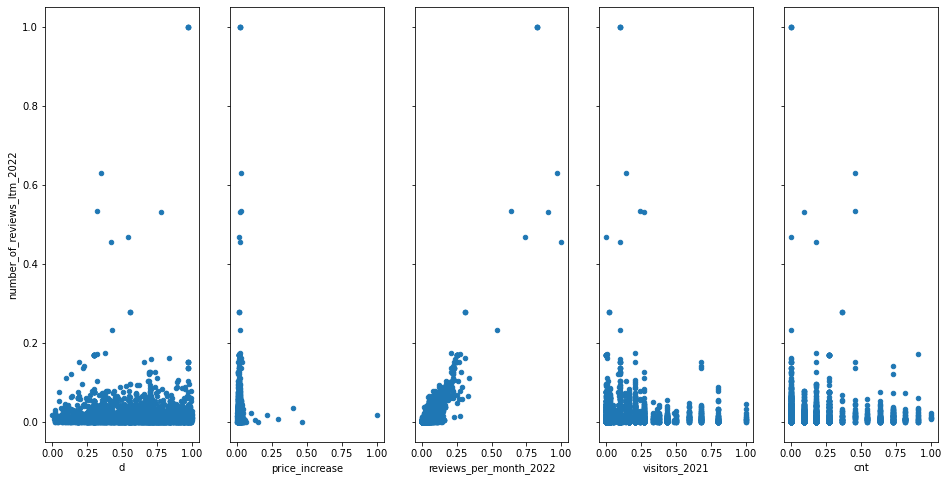

In [22]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 5, sharey=True)
df_standardised.plot(kind='scatter', x='d', y='number_of_reviews_ltm_2022', ax=axs[0], figsize=(16, 8))
df_standardised.plot(kind='scatter', x='price_increase', y='number_of_reviews_ltm_2022', ax=axs[1])
df_standardised.plot(kind='scatter', x='reviews_per_month_2022', y='number_of_reviews_ltm_2022', ax=axs[2])
df_standardised.plot(kind='scatter', x='visitors_2021', y='number_of_reviews_ltm_2022', ax=axs[3])
df_standardised.plot(kind='scatter', x='cnt', y='number_of_reviews_ltm_2022', ax=axs[4])

In [23]:
df_standardised.corr()

,d,price_increase,reviews_per_month_2022,number_of_reviews_ltm_2022,visitors_2021,cnt
d,1.000000,-0.001407,0.007799,0.032077,0.016479,-0.526805
price_increase,-0.001407,1.000000,0.026414,0.022845,-0.008061,0.013243
reviews_per_month_2022,0.007799,0.026414,1.000000,0.845709,-0.033093,-0.006250
number_of_reviews_ltm_2022,0.032077,0.022845,0.845709,1.000000,-0.032822,-0.002369
visitors_2021,0.016479,-0.008061,-0.033093,-0.032822,1.000000,0.114486
cnt,-0.526805,0.013243,-0.006250,-0.002369,0.114486,1.000000


Text(0.5, 1.0, 'Correlation Matrix')

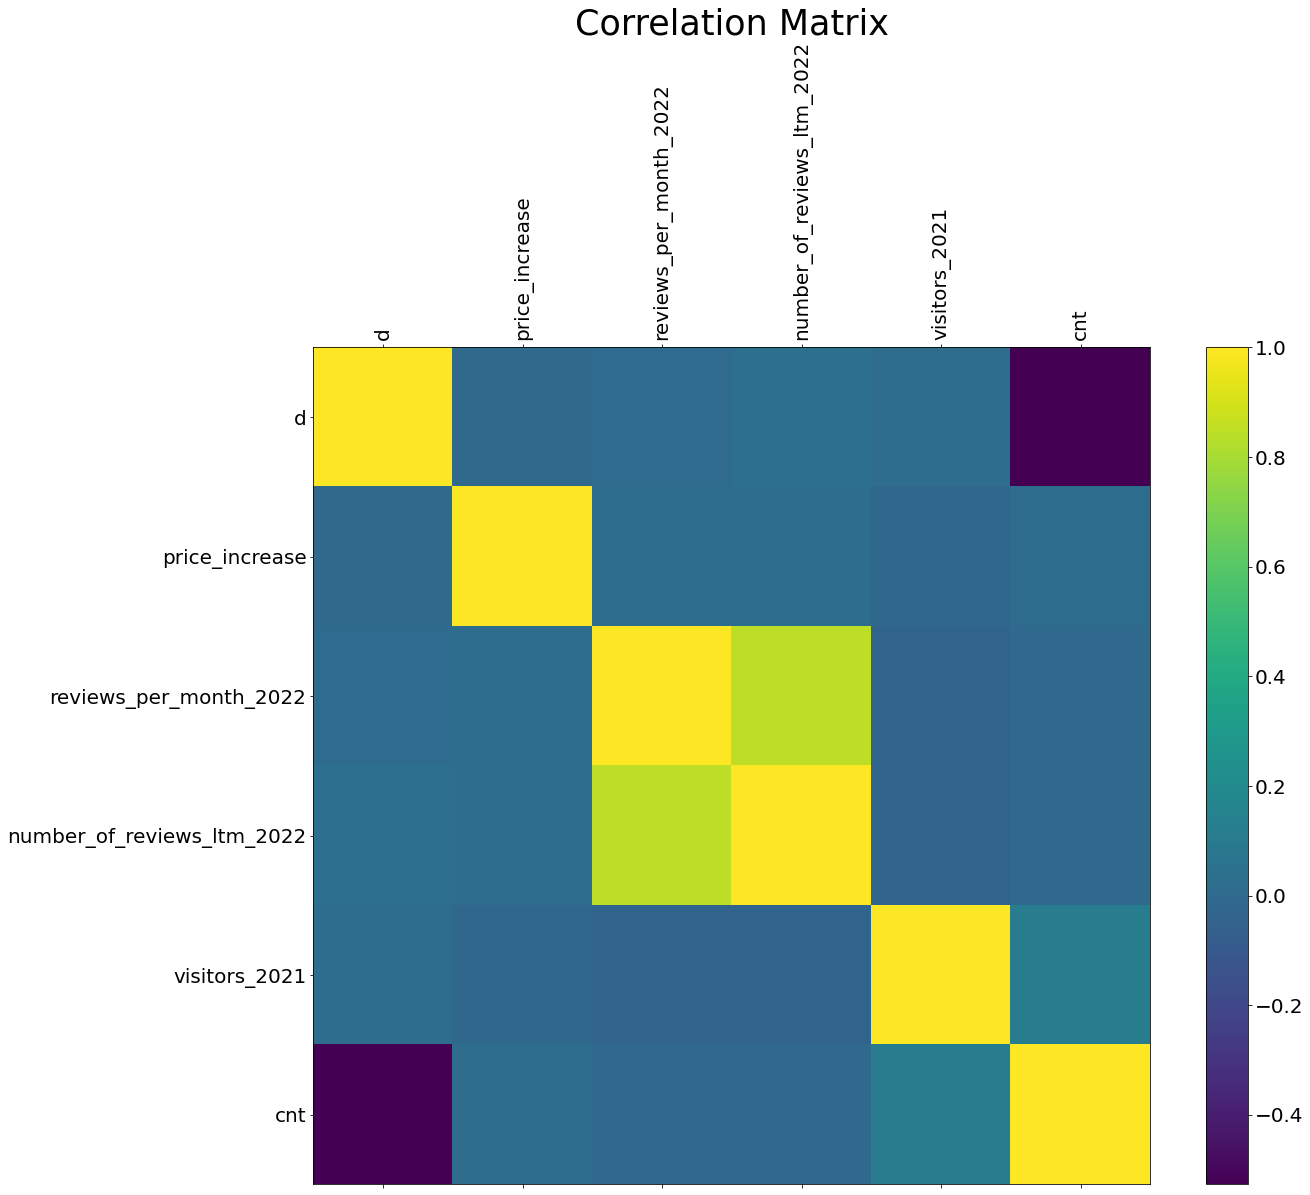

In [24]:
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(20, 15))
plt.matshow(df_final.corr(), fignum=f.number)
plt.xticks(range(df_final.shape[1]), df_final.columns, fontsize=20, rotation=90)
plt.yticks(range(df_final.shape[1]), df_final.columns, fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
plt.title('Correlation Matrix', fontsize=35)

In [25]:
# delete inf and nan
df_standardised[np.isnan(df_final)] = 0
df_standardised[np.isinf(df_final)] = 0

In [26]:
# This performs a multiple regression of expectancy against recycling:

reg_number_of_reviews_ltm_2022 = smf.ols(formula='number_of_reviews_ltm_2022 ~ d + price_increase + reviews_per_month_2022 + visitors_2021 + cnt',data=df_standardised).fit()

# And this gives a big summary of the results:
print(reg_number_of_reviews_ltm_2022.summary())

                                OLS Regression Results                                
Dep. Variable:     number_of_reviews_ltm_2022   R-squared:                       0.716
Model:                                    OLS   Adj. R-squared:                  0.716
Method:                         Least Squares   F-statistic:                     1311.
Date:                        Sat, 14 Jan 2023   Prob (F-statistic):               0.00
Time:                                17:50:38   Log-Likelihood:                 5665.3
No. Observations:                        2602   AIC:                        -1.132e+04
Df Residuals:                            2596   BIC:                        -1.128e+04
Df Model:                                   5                                         
Covariance Type:                    nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

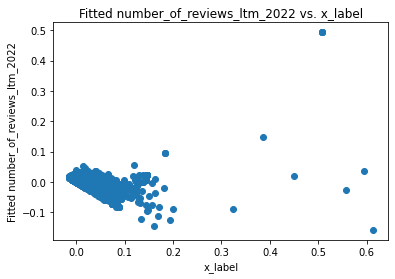

In [27]:
# plot 
plt.scatter(reg_number_of_reviews_ltm_2022.fittedvalues, reg_number_of_reviews_ltm_2022.resid)
# adding title and labels
plt.xlabel('x_label')
plt.ylabel('Fitted number_of_reviews_ltm_2022')
plt.title('Fitted number_of_reviews_ltm_2022 vs. x_label')
plt.show()

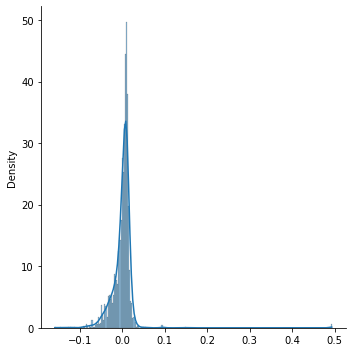

In [28]:
sn.displot(reg_number_of_reviews_ltm_2022.resid, stat="density", kde = True)

In [51]:
# Data visualisation
# Map of Airbnb in London in 2022

# 【2022 Airbnb 分布图】

import folium
from folium import plugins

# data cleaning
df_cleaned_2022 = df_2022[(df_2022["longitude"] != 0) & (df_2022["latitude"] != 0)]

# pick the columns that we need
num = df_cleaned_2022.shape[0]
lat_2022 = np.array(df_cleaned_2022["latitude"][0:num])  # get latitude
lon_2022 = np.array(df_cleaned_2022["longitude"][0:num]) # get longitude

# Making the map
london_map = folium.Map(location=[51.507222, -0.1275], 
                     zoom_start=10, 
                     control_scale=True)

airbnb2022_cluster = plugins.MarkerCluster().add_to(london_map)

for i in range(num):
    folium.Marker(location = [lat_2022[i], lon_2022[i]]).add_to(airbnb2022_cluster)

# london_map.add_child(airbnb2022_cluster)

In [ ]:
# Data visualisation
# ????

# 【20和22 共同保留且清洗的 Airbnb 分布图】

import folium
from folium import plugins

# pick the columns that we need
num = df_cleaned.shape[0]
lat_cleaned = np.array(df_cleaned["latitude"][0:num])  # get latitude
lon_cleaned = np.array(df_cleaned["longitude"][0:num]) # get longitude

# Making the map
london_map = folium.Map(location=[51.507222, -0.1275], 
                     zoom_start=10, 
                     control_scale=True)

cleaned_cluster = plugins.MarkerCluster().add_to(london_map)

for i in range(num):
    folium.Marker(location = [lat_cleaned[i], lon_cleaned[i]]).add_to(cleaned_cluster)

# london_map.add_child(cleaned_cluster)

In [ ]:
# Data visualisation
# Map of London attractions

# 【伦敦景点】

import folium
from folium import plugins

# data cleaning
df_cleaned_2022 = df_2022[(df_2022["longitude"] != 0) & (df_2022["latitude"] != 0)]

# pick the columns that we need
num = df_cleaned_2022.shape[0]
lat_2022 = np.array(df_cleaned_2022["latitude"][0:num])  # get latitude
lon_2022 = np.array(df_cleaned_2022["longitude"][0:num]) # get longitude

# Making the map
london_map = folium.Map(location=[51.507222, -0.1275], 
                     zoom_start=10, 
                     control_scale=True)

la_cluster = plugins.MarkerCluster().add_to(london_map)

for i in range(num):
    folium.Marker(location = [lat_2022[i], lon_2022[i]]).add_to(la_cluster)

# london_map.add_child(la_cluster)

In [52]:
# Data visualisation
# Heat map of the price of London Airbnb in 2022

# 【Airbnb 价格热力图】

from folium.plugins import HeatMap

# pick the columns that we need
airbnbNum = 8252  # number of Airbnb after data cleaning
lat = np.array(df_cleaned["latitude"][0:airbnbNum])  # get latitude
lon = np.array(df_cleaned["longitude"][0:airbnbNum]) # get longitude
pri = np.array(df_cleaned["price_2022"][0:airbnbNum], dtype=float) # price in 2022

# Make the data in the form of [latitude, longitude, price]
Airbnbdata = [[lat[i], lon[i], pri[i]] for i in range(airbnbNum)] 

# Making the map
mapData = folium.Map(location=[51.507222, -0.1275], 
                     zoom_start=10, 
                     control_scale=True)

HeatMap(Airbnbdata).add_to(mapData)

# mapData
